# Projet : Prédiction de l'Efficacité Énergétique des Bâtiments

**Objectifs** : Comparer ELM et BP avec différentes fonctions d'activation et architectures

## 1. Initialisation

### 1.1 Importations des Bibliothèques

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error,root_mean_squared_error, mean_squared_error, mean_absolute_percentage_error,r2_score


In [51]:
warnings.filterwarnings('ignore')
np.random.seed(42)  # Reproductibilité

## 2. Préparation des Données

### 2.1 Chargement et Exploration

In [52]:
df = pd.read_excel("ENB2012_data.xlsx")
print("\n Les Données")
display(df.head(5))
print("\n les Statistiques Descriptives")
display(df.describe().T.round(2))


 Les Données


,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55,21.33
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55,21.33
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55,21.33
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55,21.33
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84,28.28



 les Statistiques Descriptives


,count,mean,std,min,25%,50%,75%,max
X1,768.0,0.76,0.11,0.62,0.68,0.75,0.83,0.98
X2,768.0,671.71,88.09,514.50,606.38,673.75,741.12,808.50
X3,768.0,318.50,43.63,245.00,294.00,318.50,343.00,416.50
X4,768.0,176.60,45.17,110.25,140.88,183.75,220.50,220.50
X5,768.0,5.25,1.75,3.50,3.50,5.25,7.00,7.00
X6,768.0,3.50,1.12,2.00,2.75,3.50,4.25,5.00
X7,768.0,0.23,0.13,0.00,0.10,0.25,0.40,0.40
X8,768.0,2.81,1.55,0.00,1.75,3.00,4.00,5.00
Y1,768.0,22.31,10.09,6.01,12.99,18.95,31.67,43.10
Y2,768.0,24.59,9.51,10.90,15.62,22.08,33.13,48.03


### 2.2 Visualisations Initiales

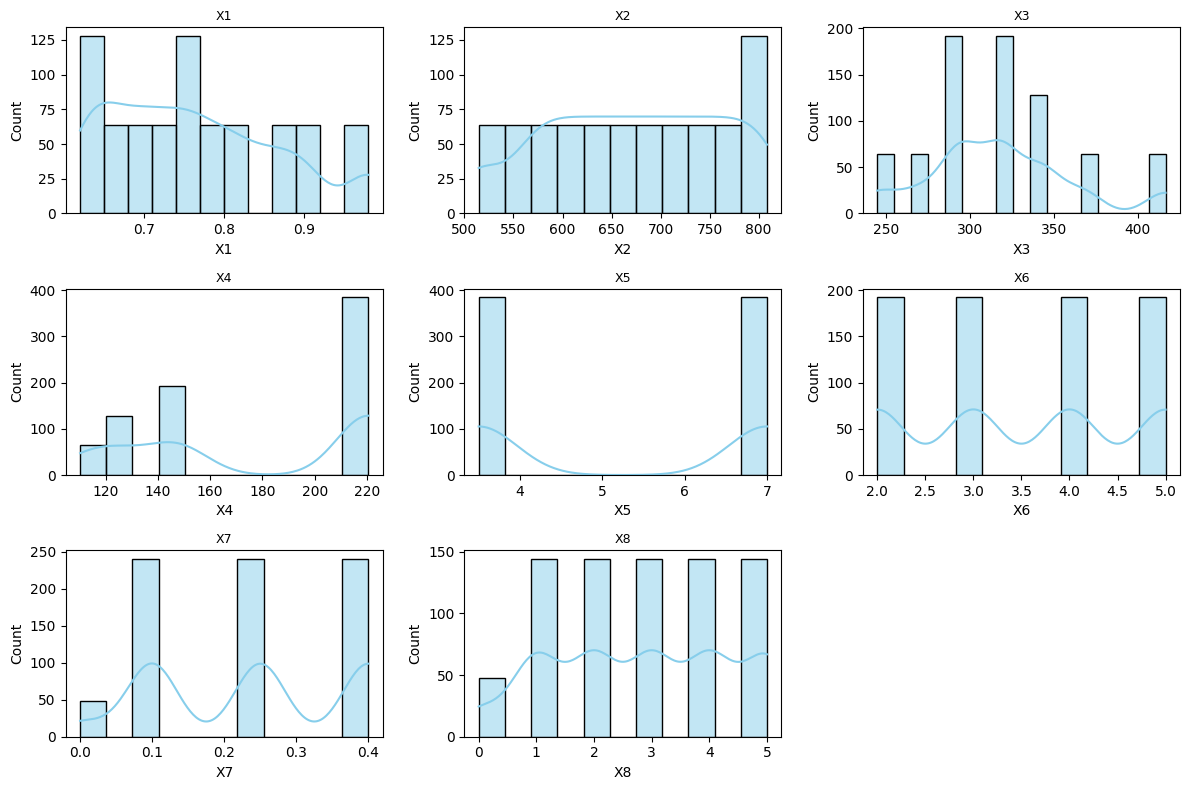

In [53]:
plt.figure(figsize=(12, 8))
for i, col in enumerate(df.columns[:-2], 1):
    plt.subplot(3, 3, i)
    sns.histplot(df[col], kde=True, color='skyblue')
    plt.title(col, fontsize=9, pad=5)
plt.tight_layout()
plt.show()

## Matrice de correlation

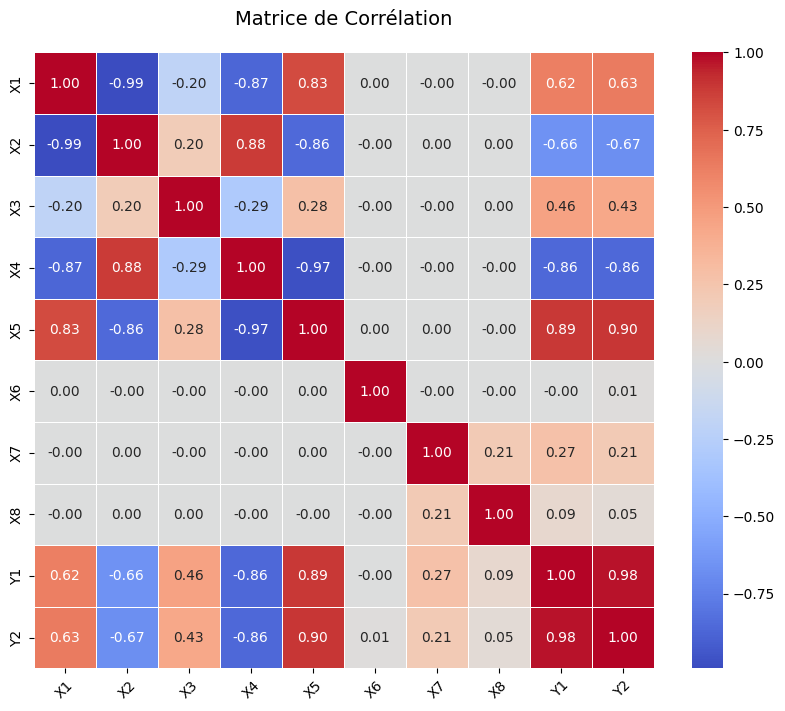

In [54]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Matrice de Corrélation", fontsize=14, pad=20)
plt.xticks(rotation=45)
plt.show()

### 2.3 Prétraitement

In [55]:
X = df.drop(['Y1', 'Y2'], axis=1).values
y = df[['Y1', 'Y2']].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, 
    test_size=0.2, 
    random_state=42
)

## 3. Implémentation des Modèles

### 3.1 Extreme Learning Machine (ELM)

In [56]:
class ELM:
    def __init__(self, input_size, hidden_size=100, activation='sigmoid'):
        np.random.seed(42)
        self.W1 = np.random.randn(input_size, hidden_size) * 0.1
        self.b1 = np.random.randn(hidden_size) * 0.1
        self.W2 = None
        self.activation = activation
        self.training_time = 0

    def _activate(self, x):
        if self.activation == 'sigmoid':
            return 1 / (1 + np.exp(-x))
        elif self.activation == 'tanh':
            return np.tanh(x)
        elif self.activation == 'relu':
            return np.maximum(0, x)

    def fit(self, X, y):
        start_time = time.time()
        H = self._activate(X @ self.W1 + self.b1)
        self.W2 = np.linalg.pinv(H) @ y
        self.training_time = time.time() - start_time

    def predict(self, X):
        H = self._activate(X @ self.W1 + self.b1)
        return H @ self.W2

## 4. Optimisation des Hyperparamètres

### 4.1 Configuration des Tests

In [63]:
elm_config = {
    'activations': ['sigmoid', 'tanh', 'relu'],
    'neurons': [50, 100, 200]
}

### 4.2 Tests pour ELM

In [58]:
from sklearn.metrics import (
    mean_squared_error, 
    r2_score, 
    mean_absolute_error,
    mean_absolute_percentage_error,
    root_mean_squared_error
)

elm_results = []
for act in elm_config['activations']:
    for n in elm_config['neurons']:
        model = ELM(X_train.shape[1], hidden_size=n, activation=act)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        # Calcul des nouvelles métriques pour Y1
        y1_true = y_test[:, 0]
        y1_pred = y_pred[:, 0]
        
        # Calcul des nouvelles métriques pour Y2
        y2_true = y_test[:, 1]
        y2_pred = y_pred[:, 1]

        metrics = {
            'Modèle': 'ELM',
            'Activation': act,
            'Neurones': n,
            # Métriques pour Y1
            'MSE_Y1': mean_squared_error(y1_true, y1_pred),
            'RMSE_Y1':root_mean_squared_error(y1_true, y1_pred),
            'MAE_Y1': mean_absolute_error(y1_true, y1_pred),
            'MAPE_Y1': mean_absolute_percentage_error(y1_true, y1_pred),
            'R2_Y1': r2_score(y1_true, y1_pred),
            
            # Métriques pour Y2
            'MSE_Y2': mean_squared_error(y2_true, y2_pred),
            'RMSE_Y2':root_mean_squared_error(y2_true, y2_pred),
            'MAE_Y2': mean_absolute_error(y2_true, y2_pred),
            'MAPE_Y2': mean_absolute_percentage_error(y2_true, y2_pred),
            'R2_Y2': r2_score(y2_true, y2_pred),
            
            'Temps (s)': model.training_time
        }
        elm_results.append(metrics)

df_elm = pd.DataFrame(elm_results)

## 5. Visualisation des Résultats

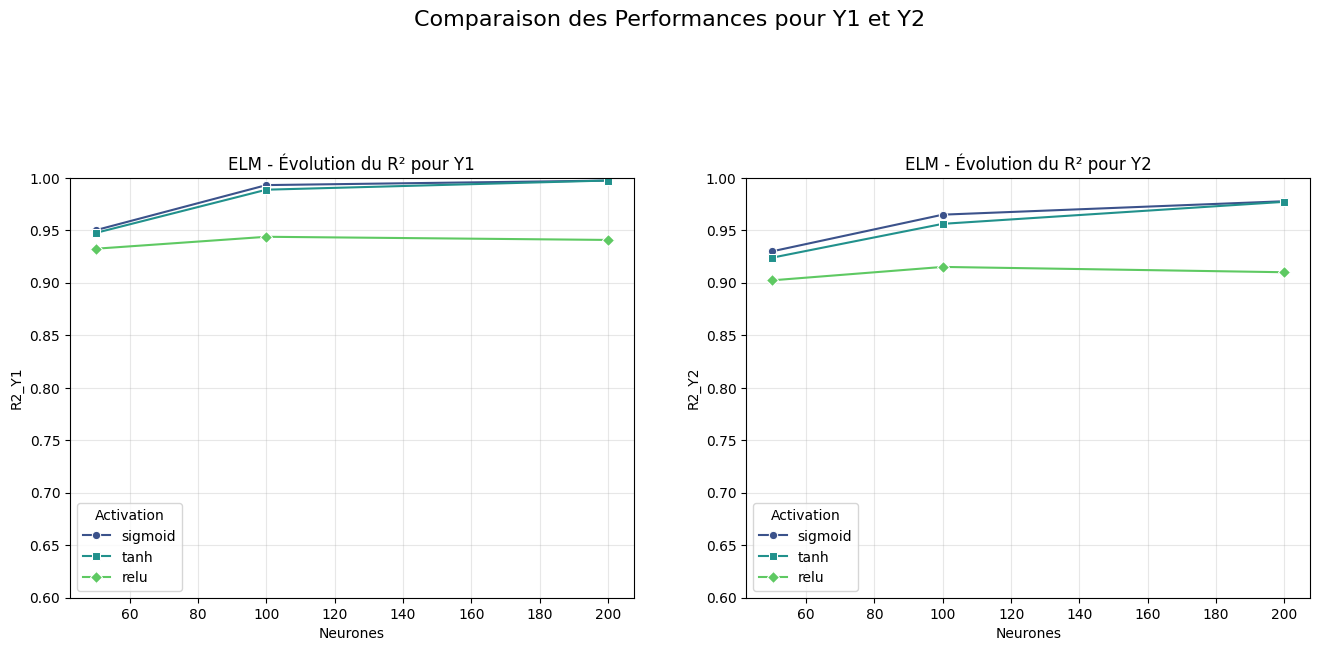

In [59]:
plt.figure(figsize=(16, 12))
plt.suptitle("Comparaison des Performances pour Y1 et Y2", fontsize=16, y=1.02)

# ELM Y1
plt.subplot(2, 2, 1)
sns.lineplot(
    data=df_elm,
    x='Neurones',
    y='R2_Y1',
    hue='Activation',
    style='Activation',
    markers=['o', 's', 'D'],
    dashes=False,
    palette='viridis'
)
plt.title("ELM - Évolution du R² pour Y1")
plt.ylim(0.6, 1.0)
plt.grid(alpha=0.3)

# ELM Y2
plt.subplot(2, 2, 2)
sns.lineplot(
    data=df_elm,
    x='Neurones',
    y='R2_Y2',
    hue='Activation',
    style='Activation',
    markers=['o', 's', 'D'],
    dashes=False,
    palette='viridis'
)
plt.title("ELM - Évolution du R² pour Y2")
plt.ylim(0.6, 1.0)
plt.grid(alpha=0.3)

## 6. Synthèse des Résultats

### 6.1 Tableau Comparatif Complet

In [60]:
df_elm
print("\nTableau Comparatif Complet")
display(df_elm.round(3))


Tableau Comparatif Complet


,Modèle,Activation,Neurones,MSE_Y1,RMSE_Y1,MAE_Y1,MAPE_Y1,R2_Y1,MSE_Y2,RMSE_Y2,MAE_Y2,MAPE_Y2,R2_Y2,Temps (s)
0,ELM,sigmoid,50,5.211,2.283,1.707,0.084,0.950,6.499,2.549,1.893,0.080,0.930,0.012
1,ELM,sigmoid,100,0.731,0.855,0.699,0.039,0.993,3.259,1.805,1.416,0.059,0.965,0.031
2,ELM,sigmoid,200,0.284,0.533,0.396,0.020,0.997,2.074,1.440,0.982,0.039,0.978,0.067
3,ELM,tanh,50,5.483,2.341,1.792,0.088,0.947,7.058,2.657,2.028,0.084,0.924,0.011
4,ELM,tanh,100,1.188,1.090,0.908,0.051,0.989,4.069,2.017,1.613,0.069,0.956,0.027
5,ELM,tanh,200,0.276,0.525,0.392,0.019,0.997,2.127,1.458,1.003,0.039,0.977,0.090
6,ELM,relu,50,7.050,2.655,1.985,0.094,0.932,9.055,3.009,2.180,0.089,0.902,0.011
7,ELM,relu,100,5.862,2.421,1.858,0.104,0.944,7.871,2.806,2.208,0.096,0.915,0.030
8,ELM,relu,200,6.176,2.485,1.961,0.092,0.941,8.341,2.888,2.213,0.090,0.910,0.073


### 6.2 Meilleures Configurations

In [61]:
best_elm = df_elm.loc[(df_elm['R2_Y1'] + df_elm['R2_Y2']).idxmax()]

comparison = pd.DataFrame({
    'Modèle': ['ELM'],
    'Activation': best_elm['Activation'],
    'Neurones': best_elm['Neurones'],
    'R² Y1': best_elm['R2_Y1'],
    'R² Y2': best_elm['R2_Y2'],
    'Temps (s)': best_elm['Temps (s)']
})

print("\n Meilleures Configurations ")
display(comparison.round(3))


 Meilleures Configurations 


,Modèle,Activation,Neurones,R² Y1,R² Y2,Temps (s)
0,ELM,sigmoid,200,0.997,0.978,0.067


## 7. Conclusion

In [62]:
print(f"""
- ELM Optimal : {best_elm['Activation']} {best_elm['Neurones']} neurones
- R² moyen : {(best_elm['R2_Y1'] + best_elm['R2_Y2'])/2:.3f} | Temps : {best_elm['Temps (s)']:.3f}s
  """)


- ELM Optimal : sigmoid 200 neurones
- R² moyen : 0.987 | Temps : 0.067s
  
